<a href="https://colab.research.google.com/github/greyhound101/Multihead_attention/blob/master/concatenate_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
fnl_acc1=list(np.load('/content/final_accuracy_last_fold1_1e-4_wn.npy',allow_pickle=True).item().values())[0]
fnl_acc2=list(np.load('/content/final_accuracy_last_fold2_1e-4_wn.npy',allow_pickle=True).item().values())[0]
fnl_acc3=list(np.load('/content/final_accuracy_last_fold3_5e-4_wn.npy',allow_pickle=True).item().values())[0]
fnl_acc4=list(np.load('/content/final_accuracy_last_fold4_1e-4_wn.npy',allow_pickle=True).item().values())[0]
fnl_acc5=list(np.load('/content/final_accuracy_last_fold5_1e-4_wn.npy',allow_pickle=True).item().values())[0]
np.mean([fnl_acc1,fnl_acc2,fnl_acc3,fnl_acc4,fnl_acc5])

0.954790015438881

In [18]:
import os
import glob
for i in glob.glob('/content/*.npy'):
  os.remove(i)

In [16]:
tot_ans=[]
tot_pre=[]

In [20]:


from sklearn.metrics import confusion_matrix
ans_1=np.load('/content/answers_last_fold1_1e-4_wn.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_last_fold1_1e-4_wn.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[107   5   0]
 [  1 244   0]
 [  2   4 179]]


In [21]:

ans_1=np.load('/content/answers_last_fold2_1e-4_wn.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_last_fold2_1e-4_wn.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[151  16   0]
 [  7 330   1]
 [  7  14 153]]


In [22]:

ans_1=np.load('/content/answers_last_fold3_5e-4_wn.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_last_fold3_5e-4_wn.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[133   5   1]
 [ 13 218   0]
 [  4   0 198]]


In [24]:

ans_1=np.load('/content/answers_last_fold4_1e-4_wn.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_last_fold4_1e-4_wn.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[110   9   5]
 [  1 322   2]
 [  7   3 169]]


In [25]:

ans_1=np.load('/content/answers_last_fold5_1e-4_wn.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_last_fold5_1e-4_wn.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[150   1  15]
 [ 16 271   0]
 [  1   2 187]]


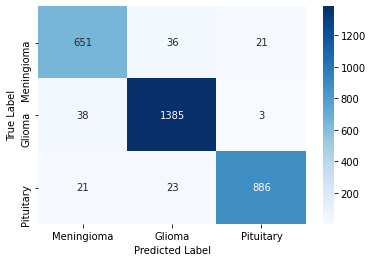

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.heatmap(confusion_matrix(tot_ans,tot_pre),annot=True,cmap='Blues', fmt='g',xticklabels=['Meningioma', 'Glioma','Pituitary' ],yticklabels=['Meningioma', 'Glioma','Pituitary' ])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('mobilenet.png')

In [27]:

history={}
history['fold1']=np.load('/content/history_last_fold1_1e-4_wn.npy',allow_pickle=True).item()
history['fold2']=np.load('/content/history_last_fold2_1e-4_wn.npy',allow_pickle=True).item()
history['fold3']=np.load('/content/history_last_fold3_5e-4_wn.npy',allow_pickle=True).item()
history['fold4']=np.load('/content/history_last_fold4_1e-4_wn.npy',allow_pickle=True).item()
history['fold5']=np.load('/content/history_last_fold5_1e-4_wn.npy',allow_pickle=True).item()



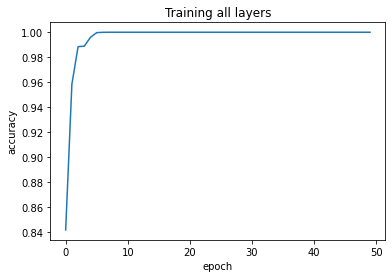

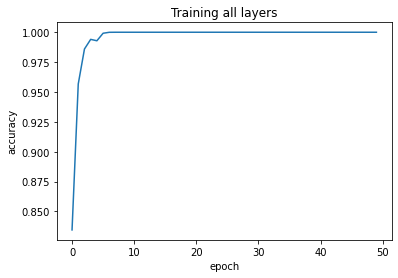

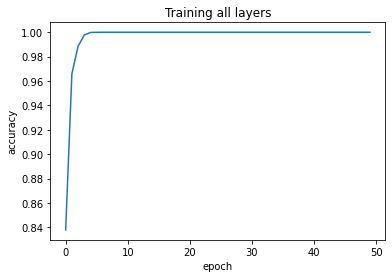

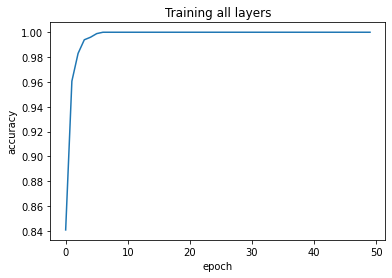

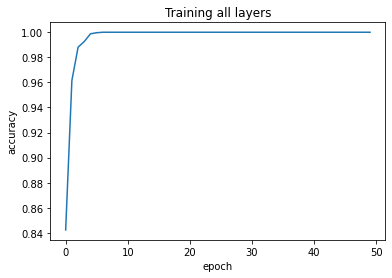

In [28]:
from matplotlib import pyplot as plt
for i in range(5):
    fold='fold'+str(i+1)
    fold1='fold_'+str(i+1)
    plt.plot(history[fold][fold1]['accuracy'])
    plt.title('loss for fold '+str(i))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Training all layers')
    plt.show()

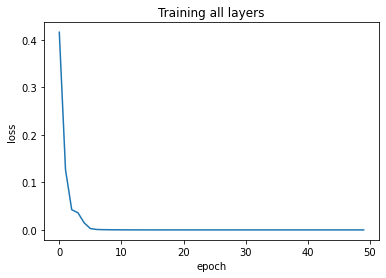

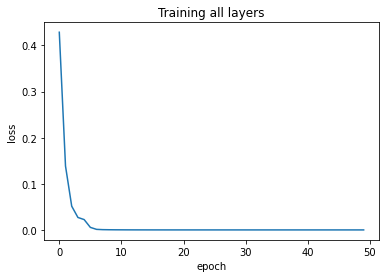

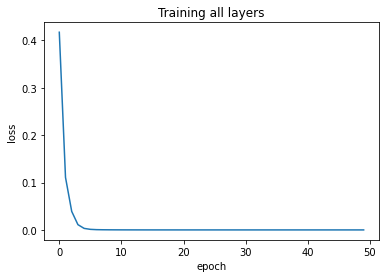

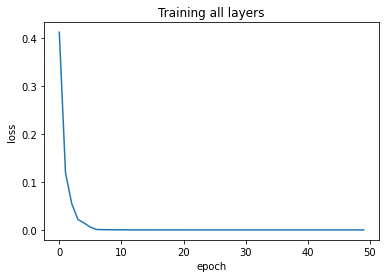

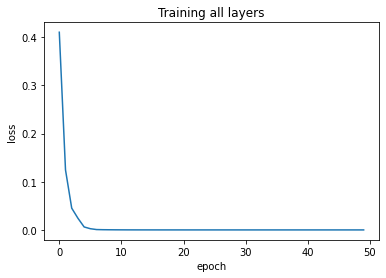

In [29]:
from matplotlib import pyplot as plt
for i in range(5):
    fold='fold'+str(i+1)
    fold1='fold_'+str(i+1)
    plt.plot(history[fold][fold1]['loss'])
    plt.title('loss for fold '+str(i))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training all layers')
    plt.show()